In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import scipy.sparse
from scipy.sparse.linalg import spsolve
from utils import *

In [2]:
folder_path = "img/archive (1)/"

source = cv2.imread(folder_path + "source_flat.jpg")
mask = cv2.imread(folder_path + "mask_flat.jpg", cv2.IMREAD_GRAYSCALE) 
#edges = cv2.Canny(source, 50, 200)
edges = cv2.dilate(edges, None)
edges[mask == 0] = 0    

#let's plot the image to have a better understanding of the before and after
triple_image(source, mask, edges)

NameError: name 'edges' is not defined

In [ ]:
#poisson illumination changes
def poisson_illumination_change(source, mask, offset):
    # Calculate image dimensions
    if len(source.shape) == 2:
        height, width = source.shape
        channels = 1
    else:
        height, width, channels = source.shape
    print(f"source: {source.shape}, mask: {mask.shape}")
    
    # Extract and prepare the mask
    mask = mask[:height, :width]
    mask_binary = (mask != 0).astype(np.float32)

    # Create a Laplacian matrix
    laplacian = laplacian_matrix(height, width)

    # Modify the Laplacian matrix for boundary conditions
    for y in range(1, height - 1):
        for x in range(1, width - 1):
            if mask[y, x] == 0:
                k = x + y * width
                laplacian[k, k] = 1
                laplacian[k, k + 1] = 0
                laplacian[k, k - 1] = 0
                laplacian[k, k + width] = 0
                laplacian[k, k - width] = 0

    print("Solving linear system...")
    print(f"laplacian_matrix: {laplacian.shape}")
    # Flatten the source and target images
    source_flat = source.reshape((-1, channels))

    print(f"source: {source.dtype}")
    # Calculate Laplacian of the source image
    laplacian_source = finite_full_gradient_xy(source).reshape((-1, channels))
    laplacian_source[edges.flatten() == 0] = 0
    laplacian_source = laplacian_source.reshape((-1, channels))#.astype("uint8")

    # Update Laplacian values outside the mask with target values
    laplacian_source[mask_binary.flatten() == 0] = source_flat[mask_binary.flatten() == 0]

    #laplacian_source[mask_binary.flatten() == 1] = np.exp(laplacian_source[mask_binary.flatten() == 1])

    # Solve the linear system to get the blended image 
    laplacian = laplacian.tocsc()
    blended_flat = spsolve(laplacian, laplacian_source)

    # Clip pixel values to the [0, 255] range
    blended_flat = np.clip(blended_flat, 0, 255).astype('uint8')

    # Reshape and update the target image with the blended channel
    target = blended_flat.reshape((height, width, channels))

    return target

cv2.imwrite("illumination_test.png", poisson_illumination_change(source, mask, (0, 0)))

source: (533, 800, 3), mask: (533, 800)
Solving linear system...
laplacian_matrix: (426400, 426400)
source: uint8


True

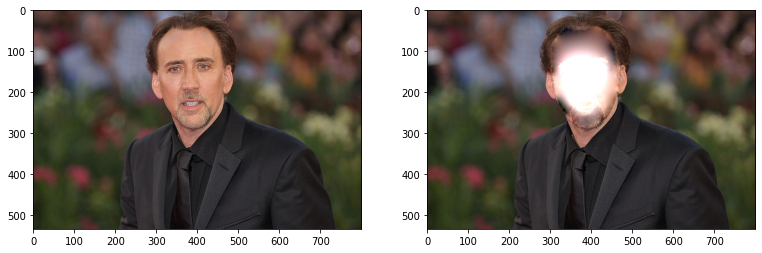

In [ ]:
edited = cv2.imread("illumination_test.png")

double_image(source, edited)